In [1]:
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os
import logging
import numpy as np
import tensorflow as tf
import seaborn as sns

In [2]:
def _df(data):
    df = pd.DataFrame(data)
    for c in range(df.shape[1]):
        mapping = {df.columns[c]: c}
        df = df.rename(columns=mapping)
    return df

In [3]:
data = pd.read_excel("data/new_data.xlsx")
data.drop(columns=["Unnamed: 0"],inplace=True)

columns = list(data.columns)

X = data.iloc[:,0:-1]
Y = data.iloc[:,-1]

x_nor= MinMaxScaler().fit_transform(X)

In [4]:
data = np.column_stack((x_nor,Y))
data_df = pd.DataFrame(data, columns=columns)
data_df
print(data.shape)
data_df.head()

(111, 9)


,d_p,d_hole,l_e,f_cg,f_cm,anchore_type,masonry_type,f_max_exp,failure_mode
0,0.428571,1.0,1.0,0.286264,1.0,0.666667,0.0,0.483654,1.0
1,0.428571,1.0,1.0,0.286264,1.0,0.666667,0.0,0.310577,1.0
2,0.428571,1.0,1.0,0.286264,1.0,0.666667,0.0,0.425962,1.0
3,0.428571,1.0,1.0,0.286264,1.0,0.666667,0.0,0.502885,2.0
4,0.428571,1.0,1.0,0.286264,1.0,0.666667,0.0,0.541346,2.0


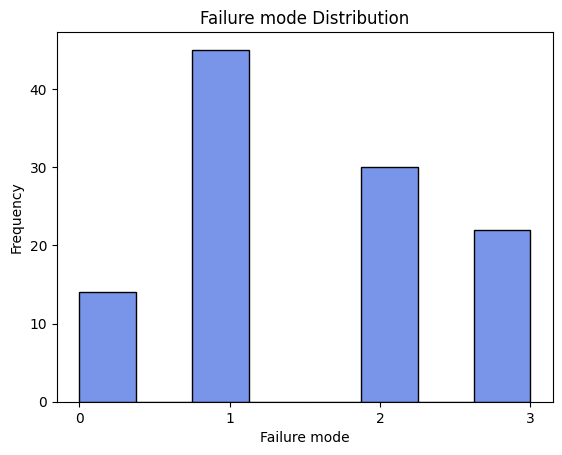

In [5]:
## Checking the frequency for each class (Failure Mode)
sns.histplot(data=data_df, x="failure_mode", color='royalblue', alpha=0.7)
plt.title("Failure mode Distribution")
plt.xlabel("Failure mode")
plt.xticks([0,1,2,3])
plt.ylabel("Frequency")
plt.show()

## Tabular GAN Model

In [6]:
tf.get_logger().setLevel(logging.ERROR)

class Gan():

    def __init__(self, data):


        self.data = data
        self.n_epochs = 200

    # Genereta random noise in a latent space
    def _noise(self):
        noise = np.random.normal(0, 1, self.data.shape)
        return noise

    def _generator(self):
        model = tf.keras.Sequential(name="Generator_model")
        model.add(tf.keras.layers.Dense(15, activation='relu',
                                        kernel_initializer='he_uniform',
                                        input_dim=self.data.shape[1]))
        model.add(tf.keras.layers.Dense(30, activation='relu'))
        model.add(tf.keras.layers.Dense(
            self.data.shape[1], activation='linear'))
        return model

    def _discriminator(self):
        model = tf.keras.Sequential(name="Discriminator_model")
        model.add(tf.keras.layers.Dense(25, activation='relu',
                                        kernel_initializer='he_uniform',
                                        input_dim=self.data.shape[1]))
        model.add(tf.keras.layers.Dense(50, activation='relu'))
        # sigmoid => real or fake
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        return model

    # define the combined generator and discriminator model,
    # for updating the generator
    def _GAN(self, generator, discriminator):
        discriminator.trainable = False
        generator.trainable = True
        model = tf.keras.Sequential(name="GAN")
        model.add(generator)
        model.add(discriminator)
        model.compile(loss='binary_crossentropy', optimizer='adam')
        return model

    # train the generator and discriminator
    def train(self, generator, discriminator, gan):

        # determine half the size of one batch, for updating the  discriminator
        # manually enumerate epochs
        for epoch in range(self.n_epochs):
            
            # Train the discriminator
            generated_data = generator.predict(self._noise())
            labels = np.concatenate([np.ones(self.data.shape[0]), np.zeros(self.data.shape[0])])
            X = np.concatenate([self.data, generated_data])
            discriminator.trainable = True
            d_loss , _ = discriminator.train_on_batch(X, labels)

            # Train the generator
            noise = self._noise()
            g_loss = gan.train_on_batch(noise, np.ones(self.data.shape[0]))


            print('>%d, d1=%.3f, d2=%.3f' %(epoch+1, d_loss, g_loss))

        return generator


In [7]:
model = Gan(data=data_df)
generator = model._generator()
descriminator = model._discriminator()
gan_model = model._GAN(generator=generator, discriminator=descriminator)
trained_model = model.train(
    generator=generator, discriminator=descriminator, gan=gan_model)

4/4 [==============================] - 0s 3ms/step
>1, d1=0.738, d2=0.653
4/4 [==============================] - 0s 3ms/step
>2, d1=0.697, d2=0.669
4/4 [==============================] - 0s 3ms/step
>3, d1=0.688, d2=0.676
4/4 [==============================] - 0s 3ms/step
>4, d1=0.694, d2=0.701
4/4 [==============================] - 0s 3ms/step
>5, d1=0.661, d2=0.755
4/4 [==============================] - 0s 3ms/step
>6, d1=0.649, d2=0.746
4/4 [==============================] - 0s 3ms/step
>7, d1=0.653, d2=0.776
4/4 [==============================] - 0s 2ms/step
>8, d1=0.626, d2=0.765
4/4 [==============================] - 0s 1ms/step
>9, d1=0.616, d2=0.798
4/4 [==============================] - 0s 2ms/step
>10, d1=0.575, d2=0.824
4/4 [==============================] - 0s 3ms/step
>11, d1=0.582, d2=0.849
4/4 [==============================] - 0s 2ms/step
>12, d1=0.559, d2=0.900
4/4 [==============================] - 0s 2ms/step
>13, d1=0.548, d2=0.919
4/4 [=============================

In [8]:
noise = np.random.normal(0, 1,(1000,9)) 
generated_data = _df(data=trained_model.predict(noise))

32/32 [==============================] - 0s 2ms/step


In [9]:
print(generated_data.shape)
generated_data.rename(columns= {0:'d_p' , 1:"d_hole", 2: 'l_e',3:'f_cg',4: 'f_cm' ,5: "anchore_type", 6:"masonry_type",7:"f_max_exp",8:"failure_mode" } ,inplace=True)
generated_data.head()

(1000, 9)


,d_p,d_hole,l_e,f_cg,f_cm,anchore_type,masonry_type,f_max_exp,failure_mode
0,0.646669,-0.315394,-0.542088,0.808456,0.661576,1.657302,1.333161,0.735962,1.278399
1,1.019070,0.035179,-0.369328,0.488657,-0.118352,2.574922,1.098196,1.950988,2.611279
2,1.417348,-0.787739,0.344419,1.069244,0.166702,3.432566,1.420440,2.450958,3.127614
3,0.246047,-0.007379,-0.149558,0.151169,0.148199,0.780398,0.295189,0.634450,0.682909
4,0.871234,-0.401319,-0.708741,0.844380,0.391476,2.334630,1.346043,1.589443,2.461462


In [10]:
failure_mode_max=generated_data["failure_mode"].max()
failure_mode_min=generated_data["failure_mode"].min()
failure_mode_split_points = np.linspace(failure_mode_min, failure_mode_max, 3 + 1)

generated_data["failure_mode"] = np.digitize(generated_data["failure_mode"], failure_mode_split_points) -1  # -1 to make it zero-indexed
generated_data
# failure_mode_split_points


,d_p,d_hole,l_e,f_cg,f_cm,anchore_type,masonry_type,f_max_exp,failure_mode
0,0.646669,-0.315394,-0.542088,0.808456,0.661576,1.657302,1.333161,0.735962,0
1,1.019070,0.035179,-0.369328,0.488657,-0.118352,2.574922,1.098196,1.950988,1
2,1.417348,-0.787739,0.344419,1.069244,0.166702,3.432566,1.420440,2.450958,1
3,0.246047,-0.007379,-0.149558,0.151169,0.148199,0.780398,0.295189,0.634450,0
4,0.871234,-0.401319,-0.708741,0.844380,0.391476,2.334630,1.346043,1.589443,1
...,...,...,...,...,...,...,...,...,...
995,1.022013,-0.044501,-0.157664,0.233531,0.112904,1.384833,0.954740,1.096624,0
996,0.575371,-0.563200,-1.473344,1.072377,1.046749,2.899129,0.951454,1.512194,1
997,0.586592,-0.385421,-0.523563,0.677935,0.335725,1.815472,0.655289,1.079026,0
998,0.326300,-0.081489,-0.781758,0.396973,0.119132,1.798535,0.698726,1.193412,0


In [13]:
generated_data.to_excel("data/generated_data.xlsx")